# 2021 WRF-Python Tutorial #
## Michaela Sizemore ##
## NCAR/CISL/VAST ##

## Topics Covered Today ##
 - Overview 
 - Getting started 
 - Using WRF-Python functions
 - Plotting with WRF-Python using Cartopy and Matplotlib


## What is WRF-Python? ##

 - WRF-Python is a post-processing tool similar to NCL's WRF Package
     - Contains over 30 diagnostic routines (CAPE, storm relative helicity, cloud top temperature, etc)
     - Interpolation routines (level, cross section, surface)
     - Utilities to help with plotting via cartopy, basemap, PyNGL
 - WRF-ARW only
 - WRF-Python is **NOT** a tool for running the WRF-ARW model with Python 
 
## Where can I find help with WRF-Python? ##
 - [GitHub Repository](https://github.com/NCAR/wrf-python) 
     - WRF-Python is open source, and we highly encourage public input with it's development process
     - Great place to go if you find bugs in the code, have any functionality you want to see, or to ask and answer community questions
 - [WRF-Python Talk](https://groups.google.com/a/ucar.edu/g/wrfpython-talk) Google Group 
     - A bit more for code issues, user support, and general questions
 - [WRF-Python ReadTheDocs](https://wrf-python.readthedocs.io/en/latest/) page
     - Contains all API, installation guides, table of available diagnostics, FAQs, and plotting examples 

## What happened NCL's WRF package/ Why is this in Python? ##
NCAR has made the decision to "pivot to Python" as the scripting language platform of choice for future development of analysis and visualization tools. Currently, the NCL software is in "maintenance mode" meaning new features will not be added nor will non-critical software defects be addressed. With that being said, The GeoCAT Team is dedicated to providing tutorial and example materials to help aid NCL users in the transition from NCL to Python. 

# Getting Started #

To begin, we will first read in the necessary packages we will be using today. Ensure that you get no errors from this process. If you do have any errors, try the following to troubleshoot:
 - Make sure the conda environment is activated for the tutorial
     - You should see the conda environment on the far left side of the command line you are using 
     - If it is not correct, run ***conda deactivate*** then ***conda activate ENV NAME***
 - Make sure the environment contains all necessary packages
     - If you recieve an error saying a package is not found, in the command line (with the environment activated) run ***conda list*** and ensure the package giving you an error is installed
 - Ensure your packages have the correct version
     - This can also be seen through ***conda list*** on the right side of the print out 
     - The versions for the packages being used today will be:
     
If you are still having issues, please let us know in the chat and someone will try to help you.

**Note:** if your Jupyter Notebook crashes at any point, make sure to re-run the following code cell again before any others

In [1]:
from __future__ import print_function

# This jupyter notebook command inserts matplotlib graphics in 
# to the workbook
%matplotlib inline

# Modify these to point to your own files
WRF_DIRECTORY = "/path/to/wrf_tutorial_data" # mine was "/Users/misi1684/wrf_python_tutorial/wrf_tutorial_data"
WRF_FILES = ["wrfout_d01_2005-08-28_00_00_00",
             "wrfout_d01_2005-08-28_12_00_00",
             "wrfout_d01_2005-08-29_00_00_00"]


# Do not modify the code below this line
#------------------------------------------------------
# Turn off annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Make sure the environment is good
import numpy as np
import cartopy
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from xarray import DataArray
import os

from wrf import (getvar, interplevel, vertcross, 
                 vinterp, CoordPair, ALL_TIMES, to_np,
                 xy_to_ll, ll_to_xy, get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim)

_WRF_FILES = [os.path.abspath(os.path.expanduser(
    os.path.join(WRF_DIRECTORY, f))) for f in WRF_FILES]

# Check that the WRF files exist
for f in _WRF_FILES:
    if not os.path.exists(f):
        raise ValueError("{} does not exist. "
            "Check for typos or incorrect directory.")

# Create functions so that the WRF files only need
# to be specified using the WRF_FILES global above
def single_wrf_file():
    global _WRF_FILES
    return _WRF_FILES[0]

def multiple_wrf_files():
    global _WRF_FILES
    return _WRF_FILES

print("All tests passed!")


All tests passed!


## Reading in wrfout files and taking a look at the data they contain ##

Now that all tests have passed, lets try reading in a single wrfout file with netcdf4 and looking at what data it contains.

The variable 'wrfin' from here on be used for all single variable examples

In [96]:
file_path = single_wrf_file() # Necessary due to single_wrf_file being a function

wrfin = Dataset(file_path)
# print(wrfin)

# Try extracting 'V' variable
var = wrfin.variables['']
# print(var)
# Other options of things you can look at:
# 'XLAT' 'XLAT' 

# Lets look at a specific attribute, 'coordinates', of that variable
coords = var.coordinates
# print(coords)

# To see all data presented in a numpy array try:
var_all_dat = var[:]
# print(var_all_dat)

# To select for a specific time index
t0_data = var[0]
# print(t0_data)

## A quick sidebar about subsetting wrfout files ##

You may find that your wrfout file is just too large for what you need to do with it (like sending it in an email or uploading to GitHub). To solve this, you may want to subset the file data for only the data variables necessary for your project. This will allow you to shrink the file down to a more 'bare-bones' version of the original file which will also reduce the file size. This is when using xarray may be a good idea.

### Where can I find out what variables are necessary for a WRF-Python variable? ###

Generally, the variables defined below are enough, but sometimes an extra variable is necessary to perform the function. The [source code](https://github.com/NCAR/wrf-python/blob/develop/src/wrf/routines.py) of 'getvar' is the best place to start finding the variables used. You can usually track the variables through your IDE of choice by command-clicking them, but if that isn't working, the GitHub repository contains the full source code for wrf-python. The quick guide on this step is as follows:
 
 1. Open the source code in GitHub for the *getvar* function. This is the 'routines.py' file.
 
 
 2. Starting at line 38, there is a list called _FUNC_MAP which really tells getvar where to look for the correct routines for processing the data necessary for the requested variable.
 
 
 3. For this example, I am wanting 'height_agl'. So I will scroll to height_agl on line 82 and see that it uses the function 'get_height_agl'
 
 
 4. I will then scroll to the top and see that 'get_height_agl' is is in the file 'g_geoht'
 
 
 5. Knowing this, I will return to the src/wrf directory and go to the g_geoht.py file 
 
 
 6. Next, look at the function _get_geoht starting on line 12. This is the "inner" wrapper function, that means it does most of the heavy lifting of the "outter" wrapper, which we as users interact with. 
 
 
 7. In looking at the inner wrapper, I see that it needs either the variable "PH" with "PHB" and "HGT" (line 87) or the variable "GMT" with variable "HGT_M" (line 99).
 
 
 8. So if I were subsetting my dataset with the code below, I would want to make sure that the variables from line 87 or 99 were included in 'toinclude'.
 
 
 9. Then I would run this code with my wrfout file and test it in my Python code to ensure all necessary data variables were included. If any variable is missing, you would be given and error message telling you which variable is missing, at which point you would just need to update the 'toinclude' section and re-run the subsetting code.

In [97]:
import xarray as xr

# Open data file using xarray 
ds = xr.open_dataset(file_path, decode_times=False)
# print(ds)

# This defines the file name, you can change this to be whatever you like as long as it is in quotes
new_file = "single_wrf_file_subset.nc"

# This represents the data variables that you want to extract. 
# These are the minimum variables needed for most wrf functions
toinclude = ['HGT', 'QVAPOR', 'QRAIN', 'QCLOUD', 'P', 'PB', 'PHB', 'PH', 'T', 'U', 'V']

# This will create a new data file with the variables and file name provided
# ds[toinclude].to_netcdf(new_file)

# Using WRF-Python Functions #

We will now use the 'getvar' function to process the data from the wrfout file and return a specified variable. This variable can later be used in plotting with Cartopy.

In [101]:
# Use 'wrfin' variable 

# Let's use wrf.getvar() to define and extract "height" variable
# Use two different timeidx values: 'ALL_TIMES' and and int between 0 and 3
hgt = getvar(wrfin, "", timeidx=, units='km') # What is the difference when using ALL_TIMES vs an int?

# print(hgt.shape)
# print(hgt)

# What do you notice when using different time indexes? 

### Now let's look at some of the arguments we can use with getvar ###
A more in depth look at all available diagnostics can be found on the WRF-Python website in the [getvar user API](https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html#wrf.getvar).

In [102]:
# These examples will use the 'wrfin' variable. 

# Find sea level pressure (slp)
slp = getvar(wrfin, 'slp') # This uses default units of hPa, but can be changed. Try units like Pa, mb, or mmhg  
# print(slp)

# Find temperature (temp)
temp = getvar(wrfin, 'temp') # Default units are Kelvin (K), try with degC or degF as well
# print(temp)

### Try with multiple wrfout files ###

From here on out, 'wrf_files' will be used for multi-file examples

In [103]:
# Start by defining the file path using the conveniance function from above
file_paths = multiple_wrf_files()

wrf_files = [Dataset(f) for f in file_paths] # Three files read in
# print(wrf_files)

# Find slp and use the arguments for timeidx and units for practice
slp = getvar(wrf_files, 'slp', timeidx=ALL_TIMES, units='mb') # Difference between All_TIMES and using int?
# print(slp)

## Combining variables across multiple files ##
 There are two methods for combining variables across multiple files:
  - **cat** - combines the the variable along the Time dimension (Note: you must order the files yourself)
  - **join** - creates a new left-most dimension for each file

    *Default is 'cat'*

To extract all times in to a single array, set timeidx to wrf.ALL_TIMES (an alias for None).

We will first use the 'cat' method in the following block, then the 'join' method in the block after.

In [109]:
# Because we have already defined the file_paths and wrf_files variables above, we will skip redefining them here

# Find slp using ALL_TIMES and 'cat' method
slp = getvar(wrf_files, 'slp', timeidx=, method='')

# print(slp.shape) # Notice the shape of the array


In [110]:
# Try with the 'join' method instead
slp = getvar(wrf_files, "slp", timeidx=, method="")

# print(slp.shape) # Notice the shape of the array

# What is different between the two methods? Is this what we expected?

## Using WRF-Python interpolation routines ##

**Three categories of routines**
 - *interplevel* - linear interpolation to a horizontal plane at a specified height or pressure level.
 - *vertcross* - vertical cross section interpolation to a vertical plane through two specified points (or a pivot point and angle).
 - *vinterp* - interpolates to a "surface", which could be pressure levels or temperature levels like theta-e. A smarter version of interplevel.

User API for interpolation routines can be found [here](https://wrf-python.readthedocs.io/en/latest/user_api/index.html#interpolation-routines).

### Interplevel function ###
 - The easiest way to get a field at a specified height or pressure vertical level (500 mb, 5000 m, etc).
 - Uses linear interpolation, which is fast and generally good enough for plotting.
 - You should use vinterp for geopotential height if you want more accuracy, since the interpolation is done with the decaying exponential pressure profile.

In [111]:
# Use single file path (wrfin) for this example
# Extract pressure and z/height variables for time index 0
pres = getvar()
ht = getvar() # Use units of meters ('m')

# Create variable 'ht_500' for interpolation at the 500 m level
ht_500 = interplevel() # What does the last argument of this function represent? What are the units for it?

# print(ht_500)

### Vertcross function ###
The idea is to draw a horizontal line at the surface, and the cross section is defined as a vertical plane extending up from this line.

 - The new x-axis for a cross section plot is the points along the line you made. The line can be defined by:
     - Defining a start point and an end point by using (x,y) grid coordinates or (latitude, longitude) coordinates.
     - Defining a pivot point and an angle, which is useful for cross sections that will span most of the domain.
 - The new y-axis will be a set of vertical levels at default intervals (1% increments), or you can choose them yourself.
 
### Using CoordPair Class with Vertcross ###
A CoordPair is simply used to store (x,y) coordinates, or (lat,lon) coordinates. It is also possible to have (x, y, lat, lon), but that's mostly used for metadata.

The CoordPair will be used to define your cross section line.

In [112]:
# Use single file path (wrfin) for this example

# Use the wrfin XLAT and XLONG variables to create coordinates
lat_coords = wrfin.variables[]
lon_coords = wrfin.variables[]

# Numpy is used to identify the start and stop lat/lon coordinate pairs
coord_start = (np.amin(lat_coords), np.amin(lon_coords))
coord_end = (np.amax(lat_coords), np.amax(lon_coords))

start_point = CoordPair(lat=coord_start[0],lon=coord_start[1]) # Why is the coordinate selected this way?
end_point = CoordPair(lat=coord_end[0],lon=coord_end[1])

# Let's get wind speed in kts at time index 0
wspd_wdir = getvar()

# Get the height levels
ht = getvar()

# Compute the wind speed cross section
wspd_cross = vertcross()

# print(wspd_cross)

### Vinterp function ###

 - Used for interpolating a field to a type of surface:
    - pressure
    - geopotential height
    - theta
    - theta-e
 - User must specify the interpolation level(s) on the new surface.
 - A smarter, albeit slower and more complicated, version of interplevel.



In [113]:
# Use single wrf file for this example
# Extract pressure data at time index 0
pres = getvar()

# Specify theta-e levels to interpolate to                
interp_levels = [280, 285, 290, 292, 294, 
                 296, 298, 300, 305, 310]

pres_te = vinterp()

# print(pres_te)

# Other Useful Functions #
 - to_np
     - Converts xarray.DataArray to numpy array
 - xy_to_ll and ll_to_xy
     - Convert to/from grid (x,y) coordinates to/from (lat,lon) coordinates

## to_np example ##

In [114]:
# Use single wrf file for this example
# Extract pressure data at time index 0 as xarray.DataArray
pres_xarray = getvar()

# Verify data type
# print(type(pres_xarray))

# Use to_np to convert to numpy array
pres_numpy = to_np()

# Verify data type
# print(type(pres_numpy))

## xy_top_ll and ll_to_xy examples ##

In [115]:
# Use single wrf file for this example
# Convert (x=20,y=50) and (x=30,y=75) to latitude,longitude
lat_lon = xy_to_ll()

# Verify coordinates were converted
print("lat_lon coords", lat_lon)

# Convert back to x,y
x_y = ll_to_xy()

# Verify coordinates were converted
print("x_y coords", x_y)

# Let's Start Plotting! #

We will be focusing primarily on plotting with Cartopy in this section of the tutorial. We will not be covering plotting with Basemap as Basemap is no [longer being maintained](https://matplotlib.org/basemap/users/intro.html#:~:text=The%20Cartopy%20project%20will%20replace,switching%20over%20to%20use%20Cartopy.) and is encouraging users to use Cartopy instead. If you have interest in Basemap examples, there are examples on the WRF-Python readthedocs page that cover the process of using [Basemap with WRF-Python](https://wrf-python.readthedocs.io/en/latest/plot.html#matplotlib-with-basemap).

## WRF-Python Helper Function Overview ##
 - **get_cartopy**: Returns mapping object used by cartopy 
 - **latlon_coords**: Returns the latitude and longitude coordinate variables

## Start with a basic map projection of terrain height ##

*Side note: use Command+/ on mac and ctrl+/ on PC to comment/uncomment large chunks of code*

In [117]:
# Use single wrf file for this example
# Extract terrrain height variable "ter" at time index 0 using getvar
t_height = getvar()

# Extract cartopy object and lat/lon coordinates using get_cartopy and latlon_coords
cart_proj = 
lats, lons = 

# Verify cartopy object and lat/lon coordinates were processed
# print(cart_proj, '\n', lats,'\n', lons)

# Create a figure and axes object
fig = plt.figure(figsize=(10,10))
ax = plt.axes() # Define map projection style using cart_proj

# Add features to axes object 
ax.coastlines(linewidth=0.5) # What do you notice about the map style displayed?

# # Add features to the map like contour lines
# # Set contour levels 
# lvl = np.arange(250, 2750, 250) # Non-inclusive of end value (2750)

# # Add contour lines
# plt.contour(lons,
#             lats,
#             t_height, 
#             levels=lvl,
#             colors='k',
#             transform=crs.PlateCarree())

# # Add filled contour lines
# plt.contourf(lons,
#              lats,
#              t_height,
#              levels=lvl,
#              transform=crs.PlateCarree(),
#              cmap='viridis')

# # Add colorbar
# plt.colorbar(ax=ax, shrink=0.7)

# plt.show()

# Is there data missing from this projection?

## In depth look at cropping data on a projection ##

Sometimes we only want to look at a specific data range or location on a projection. We will cover two methods of cropping data on a projection: setting extents and ranges and by slicing data

### Setting extents and ranges ###

In [118]:
# Use single wrf file for this example
# Extract sea level pressure ("slp") at first time index from data
slp = getvar()

# Get the new cartopy object and the lat,lon coords
cart_proj = get_cartopy()
lats, lons = latlon_coords()

# Create a figure and axes object
fig = plt.figure(figsize=(10,10))
ax = plt.axes() # Use cart_proj for projection argument

# Add features to axes object 
ax.coastlines(linewidth=0.5) 

# Add features to the projection
# Set contour levels 
lvl = np.arange(980, 1030, 2.5)

# Add contour lines
plt.contour(lons,
            lats,
            slp, 
            levels=lvl,
            colors='k',
            transform=crs.PlateCarree())

# Add filled contour lines
plt.contourf(lons,
             lats,
             slp,
             levels=lvl,
             transform=crs.PlateCarree(),
             cmap='viridis')

# Manually set coordinate extent 


# Add colorbar
plt.colorbar(ax=ax, shrink=0.7)

plt.show()


# Overlaying Multiple Diagnostics #
In these examples, we will extract many variables and then overlay all of them on one projection. 

### Dew point temp, sea level pressure, and winds ###

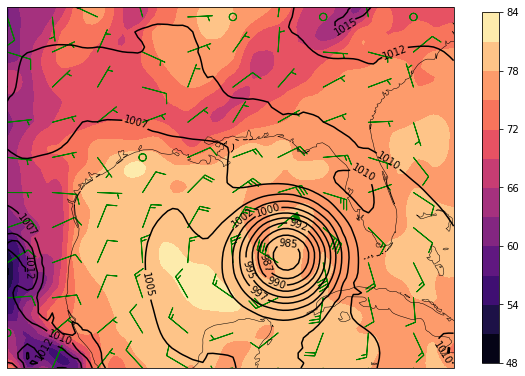

In [61]:
# Use single wrf file for this example
# Get "slp", "td2", "ua", and "va" variables at time index 0
slp = getvar(wrfin, "", timeidx=)
td2 = getvar(wrfin, "", timeidx=, units="") # Use units "degF"
u_sfc = getvar(wrfin, "", timeidx=, units="")[0,:] # subset data to match size of td2 and slp, use units "kt"
v_sfc = getvar(wrfin, "", timeidx=, units="")[0,:]

# Get the cartopy object and the lat,lon coords
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

# Create a figure and get the axes object
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=cart_proj)

# Add projection features
ax.coastlines(linewidth=0.5)

# Manually setting the contour levels
slp_levels = np.arange(980, 1030, 2.5)
td2_levels = np.arange(48, 85, 3)

# Make sea level pressure contour lines.
slp_contours = plt.contour(lons,
                           lats,
                           slp,
                           levels=slp_levels,
                           colors='k',
                           transform=crs.PlateCarree())

# Make filled countours for 2m dewpoint temperature.
plt.contourf(lons,
             lats,
             td2,
             levels=td2_levels,
             transform=crs.PlateCarree(),
             cmap='magma',
             colorbar=False)

# Plot the wind barbs, but only plot ~7 barbs in each direction.
thin = [int(x/10.) for x in lons.shape]
plt.barbs(to_np(lons[::thin[0], ::thin[1]]), # Why are we using to_np here?
          to_np(lats[::thin[0], ::thin[1]]),
          to_np(u_sfc[::thin[0], ::thin[1]]),
          to_np(v_sfc[::thin[0], ::thin[1]]),
          transform=crs.PlateCarree(),
          color = 'green')

# Add contour labels for pressure
plt.clabel(slp_contours, fmt="%i")

# Add a color bar
plt.colorbar(ax=ax, shrink=.86, extendrect=True)

plt.show()

### 850 hPa Heights and Winds with interplevel ###

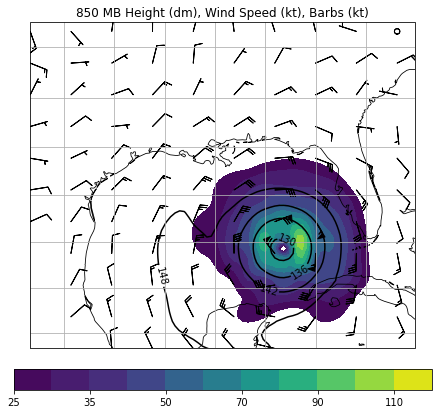

In [69]:
# Use single wrf file for this example
# Extract pressure, height, and wind variables
p = getvar(wrfin, "pressure")
z = getvar(wrfin, "z", units="dm")
ua = getvar(wrfin, "ua", units="kt")
va = getvar(wrfin, "va", units="kt")
wspd = getvar(wrfin, "wspd_wdir", units="kt")[0,:]

# Interpolate height, u and v winds, and windspeed to 850 hPa
ht_850 = interplevel() 
u_850 = interplevel()
v_850 = interplevel()
wspd_850 = interplevel()

# Get the lat/lon coordinates using ht_850
lats, lons = latlon_coords(ht_850)

# Get the map projection information using ht_850
cart_proj = get_cartopy(ht_850)

# Create the figure
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=cart_proj)

# Add coastlines to the projection
ax.coastlines(linewidth=0.8)

# Add the 850 hPa geopotential height contour lines
levels = np.arange(130, 170, 6)
contours = plt.contour(lons,
                       lats,
                       ht_850,
                       levels=levels,
                       colors="black",
                       transform=crs.PlateCarree())

plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed filled contours
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120] # Why not use np.arange/np.linspace?
wspd_contours = plt.contourf(lons,
                             lats,
                             wspd_850,
                             levels=levels,
                             cmap="viridis",
                             transform=crs.PlateCarree())

plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", 
             pad=.05, shrink=.75)

# Add the 850 hPa wind barbs, only plotting 10 barbs in each direction
# Also, skipping the border barbs.
thin = [int(x/10.) for x in lons.shape]
plt.barbs(to_np(lons[::thin[0], ::thin[1]]),
          to_np(lats[::thin[0], ::thin[1]]),
          to_np(u_850[::thin[0], ::thin[1]]),
          to_np(v_850[::thin[0], ::thin[1]]),
          transform=crs.PlateCarree(),
          length=6)

# Another way to set map extent using WRF-Python functions
# ax.set_xlim(cartopy_xlim(ht_850[10:]))
# ax.set_ylim(cartopy_ylim(ht_850[10:]))

ax.gridlines()

plt.title("850 MB Height (dm), Wind Speed (kt), Barbs (kt)")

plt.show()


### Cross Section Panel Plot ###

We will use multiple wrfout files ('wrf_files') to create a panel plot showing sea level pressure with a horizontal cross section line, and a second plot with a vertical cross section for radar reflectivity.

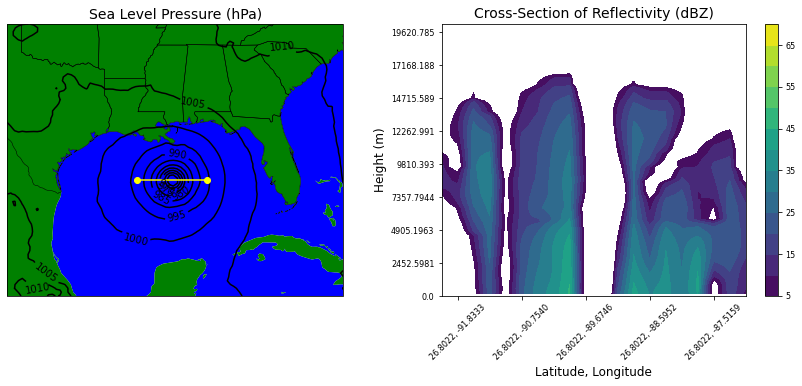

In [89]:
# Define a cross section with latitude and longitude coordinates
cross_start = CoordPair(lat=26.75, lon=-91.7)
cross_end = CoordPair(lat=26.75, lon=-86.7)

# Use multi-file wrfin 'wrf_files' for this example
# Get WRF variables
slp = getvar(wrf_files, "", timeidx=-1) # -1 is last element in the sequence
ht = getvar(wrf_files, "", timeidx=-1)
dbz = getvar(wrf_files, "", timeidx=-1)
z = 10**(dbz/10.) # Use linear z for interpolation

# Compute the vertical cross-section interpolation. Include the lat/lon
# points along the cross-section in the metadata by setting latlon to True.
z_cross = vertcross(z,
                    ht,
                    wrfin=wrf_files,
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True,
                    meta=True)

# Convert back to dBz after interpolation
dbz_cross = 10.0 * np.log10(z_cross)

# Get the lat/lon points
lats, lons = latlon_coords(slp)

# Get the cartopy projection object
cart_proj = get_cartopy(slp)

# Create a figure that will have 2 subplots (1 row, 2 columns)
# Signature: Figure.add_subplot(nrows, ncols, index, **kwargs)
fig = plt.figure(figsize=(15,5))
ax_slp = fig.add_subplot(1, 2, 1, projection=cart_proj)
ax_dbz = fig.add_subplot(1, 2, 2)

# Create states, land, and ocean features using Cartopy 
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                      name='admin_1_states_provinces_shp')
land = NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor='green')
ocean = NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                     facecolor='blue')

# Make the pressure contours
slp_levels = np.arange(950, 1030, 5)
slp_contours = ax_slp.contour(lons,
                              lats,
                              slp,
                              levels=slp_levels,
                              colors="black",
                              zorder=3,
                              transform=crs.PlateCarree())

# Add contour labels for pressure
ax_slp.clabel(slp_contours, fmt="%i")

# Draw the cross section line
ax_slp.plot([cross_start.lon, cross_end.lon], # Why can we call cross_start this way?
            [cross_start.lat, cross_end.lat],
            color="yellow", 
            marker="o",  
            zorder=3,
            transform=crs.PlateCarree())

# Draw the oceans, land, and states
ax_slp.add_feature(ocean)
ax_slp.add_feature(land)
ax_slp.add_feature(states, linewidth=.5, edgecolor="black")

# Make the contour plot for dbz
dbz_levels = np.arange(5.,75.,5.)
dbz_contours = ax_dbz.contourf(dbz_cross,
                               levels=dbz_levels,
                               cmap='viridis')

cb_dbz = fig.colorbar(dbz_contours, ax=ax_dbz)
cb_dbz.ax.tick_params(labelsize=8)

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
thin = [int(x/5.) for x in x_ticks.shape] # Only keeping ~5 horizontal ticks
ax_dbz.set_xticks(x_ticks[1::thin[0]])
ax_dbz.set_xticklabels(x_labels[::thin[0]], rotation=45, fontsize=8)

# Set the y-ticks to be height
vert_vals = to_np(dbz_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
thin = [int(x/8.) for x in v_ticks.shape] # Only keeping ~8 vertical ticks
ax_dbz.set_yticks(v_ticks[::thin[0]])
ax_dbz.set_yticklabels(vert_vals[::thin[0]], fontsize=8)

# Set the x-axis and  y-axis labels
ax_dbz.set_xlabel("Latitude, Longitude", fontsize=12)
ax_dbz.set_ylabel("Height (m)", fontsize=12)

# Add a title
ax_slp.set_title("Sea Level Pressure (hPa)", {"fontsize" : 14})
ax_dbz.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 14})

plt.show()

## Plotting multiple wrfout files ##
Chances are, you are running a simulation over many timesteps which creates multiple wrfout files. Here we will go over using many wrfout files and some of the ways you can display them together.

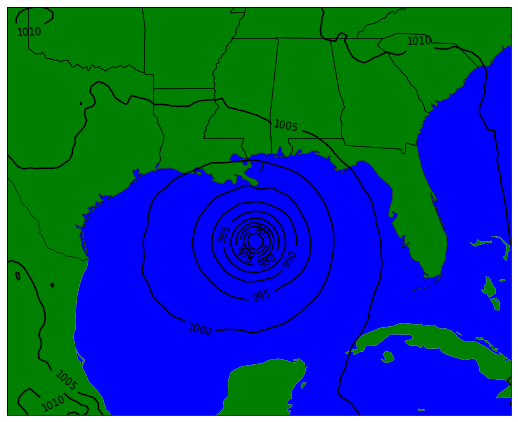

In [77]:
# Import animation specific Python packages
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Use multi-file variable 'wrf_files' for this example
# Get sea level pressure for all times
slp_all = getvar(wrf_files, "slp", timeidx=ALL_TIMES) # Why use ALL_TIMES instead of a time index?

# Get the cartopy projection object
cart_proj = get_cartopy(slp_all)

# Create figure and ax object
fig = plt.figure(figsize=(10,7.5))
ax_slp = plt.axes(projection=cart_proj)

# Download and create the states, land, and oceans using cartopy features
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                      name='admin_1_states_provinces_shp')
land = NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor='green')
ocean = NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                     facecolor='blue')

slp_levels = np.arange(950, 1030, 5)

num_frames = slp_all.shape[0] # Why are we looking at the shape to get the number of frames?

# This function is called for each frame of the animation, where
# i is the frame index. Here is where the animation frames need 
# to be created.
def animate(i):
    ax_slp.clear()
    slp = slp_all[i,:]
    
    # Get the lat/lon coordinates
    lats, lons = latlon_coords(slp)
    
    ax_slp.add_feature(ocean)
    ax_slp.add_feature(land)
    ax_slp.add_feature(states, linewidth=.5, edgecolor="black")
    
    slp_contours = ax_slp.contour(to_np(lons), 
                                  to_np(lats), 
                                  to_np(slp), 
                                  levels=slp_levels,
                                  colors="black", 
                                  zorder=5,
                                  transform=crs.PlateCarree()) 
    
    # Add contour labels for pressure
    ax_slp.clabel(slp_contours, fmt="%i")
    
    # Set the map bounds
    ax_slp.set_xlim(cartopy_xlim(slp))
    ax_slp.set_ylim(cartopy_ylim(slp))
    
    return ax_slp


# Create the animation by supplying a figure, the animation object, 
# the number of frames and an interval in milliseconds that is the 
# delay between frames.
ani = FuncAnimation(fig, animate, num_frames, interval=500)

# To work with jupyter notebook, you need to use the HTML generated
# by the HTML function in the IPython.display package.
# If you change 'to_jshtml' to be 'to_html5_video', you will get an 
# HTML5 video instead.

#HTML(ani.to_html5_video())
HTML(ani.to_jshtml())